In [1]:
import os
import sys
sys.path.append('..')

from IPython.display import clear_output

import glob
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
np.seterr(divide='ignore', invalid='ignore')

from uncertain.implicit import logMF, CAMF
from uncertain.BPR import bprMF, biasMF, TwoWayMF, bprGMF, bprMLP, ABPR, GPR
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from uncertain.utils.data import ImplicitData as Data
from uncertain.utils.training import train, run_study, load
from uncertain.utils.evaluation_implicit import test

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('New-ML_implicit')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)
        
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
base_conf = {'embedding_dim':1, 'lr':0, 'weight_decay':0}

MovieLens data prepared: 6034 users, 3125 items.
461948 train, 57605 validation and 54823 test interactions.


# logMF

In [15]:
name = 'logMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6),
              'n_negative': trial.suggest_int('neg', 5, 50)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(name, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=11)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8955547854002882, 'Rating_rec': {'MAP': array([0.39012264, 0.4675174 , 0.48989062, 0.49394174, 0.48969359,
       0.48505939, 0.47872897, 0.47176681, 0.46596826, 0.45977662]), 'Recall': array([0.03618624, 0.06318667, 0.0834691 , 0.101621  , 0.11923699,
       0.13632378, 0.15233487, 0.16610949, 0.17785397, 0.19029066])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_neg,params_wd,user_attrs_filename,state
1,1,0.496557,2022-04-12 16:11:32.522850,2022-04-12 16:17:55.599923,0 days 00:06:23.077073,4082,82,0.000396,11,8.021143e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
4,4,0.491035,2022-04-12 16:21:02.651758,2022-04-12 16:24:58.268179,0 days 00:03:55.616421,7525,90,0.000793,11,5.765706e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
2,2,0.278561,2022-04-12 16:17:55.600852,2022-04-12 16:19:57.805591,0 days 00:02:02.204739,7349,121,0.000405,43,8.030844e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
7,7,0.277822,2022-04-12 22:17:19.636735,2022-04-12 22:18:14.693679,0 days 00:00:55.056944,4550,84,0.000452,39,8.547370e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
5,5,0.276716,2022-04-12 22:15:42.161689,2022-04-12 22:16:41.715955,0 days 00:00:59.554266,9620,61,0.000135,29,9.037238e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# BPR

In [3]:
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(name, **params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=15)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(name, **base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8931105557886289, 'Rating_rec': {'MAP': array([0.35266821, 0.42989725, 0.45461827, 0.46069495, 0.46094584,
       0.45597227, 0.45125478, 0.44503072, 0.43916584, 0.43392291]), 'Recall': array([0.03179613, 0.05751806, 0.07757473, 0.0945224 , 0.11234676,
       0.12807556, 0.14046786, 0.15287402, 0.16532505, 0.17702044])}}


,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
17,17,0.465764,2022-04-12 22:59:56.901260,2022-04-12 23:05:10.902978,0 days 00:05:14.001718,6326,200,0.000367,7.157923e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
14,14,0.464566,2022-04-12 22:50:04.312645,2022-04-12 22:53:29.392765,0 days 00:03:25.080120,5761,199,0.000829,9.815757e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
19,19,0.464497,2022-04-12 23:11:05.471448,2022-04-12 23:18:13.646780,0 days 00:07:08.175332,3698,185,0.000293,9.556025e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
11,11,0.461284,2022-04-12 22:42:18.549495,2022-04-12 22:45:18.236901,0 days 00:02:59.687406,6367,199,0.000890,7.856317e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
12,12,0.461129,2022-04-12 22:45:18.237666,2022-04-12 22:47:23.229278,0 days 00:02:04.991612,5333,199,0.000940,9.963885e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# GPRMF (log)

In [4]:
name = 'biasGPRlog'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=15)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.892800466957299, 'Concordant uncertainty': 0.8208501, 'Discordant uncertainty': 0.7940694, 'corr_usup': 0.34111425626263014, 'corr_udiv': 0.15146224558006235, 'corr_isup': -0.018554713338248267, 'Rating_rec': {'MAP': array([0.35399403, 0.42956579, 0.45260192, 0.45531801, 0.45525586,
       0.45083969, 0.44704372, 0.44225248, 0.4363087 , 0.4300886 ]), 'Recall': array([0.03241056, 0.05559312, 0.07591695, 0.09302826, 0.10952116,
       0.12400724, 0.13619694, 0.14931533, 0.16101743, 0.17281463]), 'URI_global': array([-0.62534546, -0.6115171 , -0.58595771, -0.5820212 , -0.56868262,
       -0.56733013, -0.55779854, -0.54019217, -0.53685838, -0.52726105]), 'Unc_MAP_corr': 0.26573476226480486, 'URI': array([        nan, -0.14698249, -0.18769804, -0.23106558, -0.23514423,
       -0.236383  , -0.23145397, -0.22777247, -0.22504939, -0.22584311])}, 'Cuts': {'Values': array([0.8737645 , 0.79553748, 0.7296731 , 0.65644839]), 'Given': array([30170., 30170., 30170., 30045., 25366.]), 'Hits'

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
7,7,0.465418,2022-04-12 23:31:05.345343,2022-04-12 23:34:33.681534,0 days 00:03:28.336191,7659,142,0.000621,8.923129e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
15,15,0.464801,2022-04-12 23:55:30.027495,2022-04-13 00:00:04.013721,0 days 00:04:33.986226,8259,162,0.000426,9.979371e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
11,11,0.463123,2022-04-12 23:43:35.609344,2022-04-12 23:48:14.566434,0 days 00:04:38.957090,9719,190,0.000471,9.855978e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
17,17,0.460354,2022-04-13 00:06:44.361184,2022-04-13 00:10:07.262993,0 days 00:03:22.901809,8066,153,0.000679,7.941695e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
3,3,0.457904,2022-04-12 16:49:03.615190,2022-04-12 16:54:07.794990,0 days 00:05:04.179800,8282,174,0.000446,9.179161e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# GPRMF (normal)

In [5]:
name = 'biasGPR'
def init_model(**kwargs):
    return biasMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=15)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8878755266950003, 'Concordant uncertainty': 0.07358208, 'Discordant uncertainty': 0.079423174, 'corr_usup': -0.3156750024332908, 'corr_udiv': -0.2796842331503324, 'corr_isup': -0.5011188093708512, 'Rating_rec': {'MAP': array([0.38117335, 0.45376202, 0.47541708, 0.47948661, 0.47877306,
       0.47346951, 0.46843732, 0.46139766, 0.4553918 , 0.44980955]), 'Recall': array([0.0341254 , 0.05889274, 0.07848092, 0.09639352, 0.11425034,
       0.12930899, 0.14371214, 0.15729141, 0.16920136, 0.18000313]), 'URI_global': array([-0.36979871, -0.28838104, -0.24101594, -0.21162549, -0.19151939,
       -0.16799286, -0.14836666, -0.12877658, -0.11136249, -0.09801307]), 'Unc_MAP_corr': -0.3377059680201625, 'URI': array([        nan, -0.07871524, -0.08243364, -0.10299873, -0.10681674,
       -0.10741324, -0.11150405, -0.10267112, -0.10208196, -0.1012638 ])}, 'Cuts': {'Values': array([0.19802625, 0.14589233, 0.10929473, 0.08359937]), 'Given': array([30170., 30170., 30170., 30170., 29816.]), 'Hit

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
17,17,0.491976,2022-04-13 01:31:23.814129,2022-04-13 01:36:54.724199,0 days 00:05:30.910070,6663,183,0.000760,6.280630e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
12,12,0.490852,2022-04-13 01:08:56.464686,2022-04-13 01:15:33.167013,0 days 00:06:36.702327,7319,174,0.000790,6.329842e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
11,11,0.490411,2022-04-13 01:02:14.176454,2022-04-13 01:08:56.463867,0 days 00:06:42.287413,6348,167,0.000693,9.813773e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
9,9,0.488049,2022-04-13 00:48:45.182113,2022-04-13 00:55:41.156029,0 days 00:06:55.973916,4198,160,0.000748,7.393931e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
0,0,0.485830,2022-04-12 15:59:08.276513,2022-04-12 16:07:21.120897,0 days 00:08:12.844384,5697,120,0.000669,9.677339e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# TwoWayMF

In [6]:
name = 'TwoWayMF'
def init_model(**kwargs):
    return TwoWayMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=15)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8316217645878554, 'Concordant uncertainty': 0.030439654, 'Discordant uncertainty': 0.049168967, 'corr_usup': -0.46799930050317723, 'corr_udiv': 0.11916386765772345, 'corr_isup': -0.0739627658406934, 'Rating_rec': {'MAP': array([0.19522705, 0.23931057, 0.25958458, 0.26683976, 0.2714189 ,
       0.27275467, 0.27199003, 0.2715492 , 0.27021919, 0.26755294]), 'Recall': array([0.01258834, 0.02242152, 0.03127012, 0.03938742, 0.04921458,
       0.05801154, 0.06564569, 0.0736328 , 0.08102208, 0.08726836]), 'URI_global': array([0.33741672, 0.3160216 , 0.31607043, 0.31368125, 0.30031016,
       0.29222839, 0.2893369 , 0.28464492, 0.28455546, 0.2865218 ]), 'Unc_MAP_corr': -0.36530534048887764, 'URI': array([       nan, 0.08421038, 0.08269118, 0.07326753, 0.07643796,
       0.07138463, 0.10031179, 0.09442576, 0.10923861, 0.12380333])}, 'Cuts': {'Values': array([0.22488535, 0.08537182, 0.0318433 , 0.01393896]), 'Given': array([30170., 27119., 23366., 19550., 16679.]), 'Hits': array([4049.,

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
11,11,0.277930,2022-04-13 01:57:00.014087,2022-04-13 01:58:31.559615,0 days 00:01:31.545528,9628,197,0.000031,9.790153e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
16,16,0.277440,2022-04-13 02:01:40.983411,2022-04-13 02:03:49.210621,0 days 00:02:08.227210,9934,199,0.000019,5.063617e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
10,10,0.276003,2022-04-13 01:54:34.025200,2022-04-13 01:57:00.013152,0 days 00:02:25.987952,9691,196,0.000017,9.633821e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
5,5,0.275783,2022-04-13 01:50:30.765351,2022-04-13 01:51:37.727104,0 days 00:01:06.961753,4975,155,0.000037,6.990332e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
13,13,0.272032,2022-04-13 01:59:35.608947,2022-04-13 02:00:18.832449,0 days 00:00:43.223502,9840,200,0.000198,9.882729e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


In [7]:
name = 'TwoWayMFnonlog'
def init_model(**kwargs):
    return TwoWayMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=20)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8796855334439925, 'Concordant uncertainty': 0.00086003606, 'Discordant uncertainty': 0.0010439587, 'corr_usup': -0.3611976185844106, 'corr_udiv': -0.38409885838581687, 'corr_isup': -0.2554135661364677, 'Rating_rec': {'MAP': array([0.3453762 , 0.41746768, 0.4415258 , 0.44765772, 0.4462587 ,
       0.44321557, 0.44009942, 0.43662705, 0.43045711, 0.4237706 ]), 'Recall': array([0.02984496, 0.05296318, 0.07374391, 0.09069664, 0.10579754,
       0.12017105, 0.13269237, 0.14322322, 0.15506271, 0.16644855]), 'URI_global': array([-0.17001723, -0.11860634, -0.10066877, -0.08683927, -0.072308  ,
       -0.06338165, -0.05128025, -0.04219537, -0.03593571, -0.0277919 ]), 'Unc_MAP_corr': -0.2511469396928664, 'URI': array([        nan, -0.00744752, -0.0038911 , -0.00843605,  0.01616198,
        0.0202363 ,  0.02872686,  0.03108032,  0.03881145,  0.0466661 ])}, 'Cuts': {'Values': array([0.01236911, 0.0051462 , 0.00210746, 0.00064469]), 'Given': array([30170., 30059., 28791., 25369., 18619.]),

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
10,10,0.456612,2022-04-13 02:53:37.939089,2022-04-13 03:00:53.124956,0 days 00:07:15.185867,4882,54,0.000436,9.787038e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
11,11,0.450838,2022-04-13 03:00:53.125665,2022-04-13 03:06:06.023194,0 days 00:05:12.897529,4975,53,0.000454,9.996008e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
18,18,0.446829,2022-04-13 03:47:50.380791,2022-04-13 03:51:59.179922,0 days 00:04:08.799131,7599,69,0.000447,9.940790e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
14,14,0.446788,2022-04-13 03:15:20.901566,2022-04-13 03:20:02.573566,0 days 00:04:41.672000,4968,72,0.000513,9.870437e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
8,8,0.445875,2022-04-13 02:46:14.396476,2022-04-13 02:50:20.719470,0 days 00:04:06.322994,2875,101,0.000542,8.670853e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# GMF

In [8]:
name = 'GMF'
def init_model(**kwargs):
    return bprGMF(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=15)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.892855188515769, 'Concordant uncertainty': 0.859297, 'Discordant uncertainty': 0.65713805, 'corr_usup': -0.06809849831034645, 'corr_udiv': 0.06737742929202123, 'corr_isup': 0.7728286208625725, 'Rating_rec': {'MAP': array([0.34338747, 0.41597614, 0.43843222, 0.44538357, 0.44382665,
       0.43915184, 0.43451776, 0.43041402, 0.42522552, 0.42062585]), 'Recall': array([0.02946672, 0.05286816, 0.07174088, 0.08978191, 0.10499867,
       0.1192224 , 0.13213269, 0.14349316, 0.15404391, 0.16518376]), 'URI_global': array([-0.98381312, -0.95344987, -0.92978906, -0.91974974, -0.91417834,
       -0.8993325 , -0.88334063, -0.87603805, -0.87038502, -0.86333086]), 'Unc_MAP_corr': 0.20721912569965242, 'URI': array([        nan, -0.10651188, -0.14777161, -0.13117888, -0.15451972,
       -0.16107046, -0.1507512 , -0.15166091, -0.14840337, -0.15208169])}, 'Cuts': {'Values': array([0.71228554, 0.5629851 , 0.45359902, 0.35253263]), 'Given': array([30170., 30170., 30119., 29393., 26360.]), 'Hits': 

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
18,18,0.459974,2022-04-13 04:39:25.420564,2022-04-13 04:42:11.744517,0 days 00:02:46.323953,7171,185,0.000378,8.827399e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
2,2,0.458552,2022-04-12 17:22:31.697436,2022-04-12 17:29:58.012501,0 days 00:07:26.315065,4858,159,0.000113,1.440175e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
0,0,0.458433,2022-04-12 14:32:01.394526,2022-04-12 14:43:29.725522,0 days 00:11:28.330996,1567,135,0.000103,8.027095e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
19,19,0.457131,2022-04-13 04:42:11.745448,2022-04-13 04:44:48.201004,0 days 00:02:36.455556,7077,199,0.000497,1.638063e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
6,6,0.454662,2022-04-13 04:01:53.355636,2022-04-13 04:03:42.357348,0 days 00:01:49.001712,9947,168,0.000958,8.508507e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


In [9]:
name = 'GMFnonlog'
def init_model(**kwargs):
    return bprGMF(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=20)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8794666472101126, 'Concordant uncertainty': 0.020040922, 'Discordant uncertainty': 0.022756387, 'corr_usup': -0.2154629070140593, 'corr_udiv': -0.18114317546546196, 'corr_isup': -0.0319411774026345, 'Rating_rec': {'MAP': array([0.34802784, 0.41813059, 0.44368026, 0.44912164, 0.45006169,
       0.44596849, 0.44139369, 0.435275  , 0.42900677, 0.42293467]), 'Recall': array([0.02853504, 0.05067809, 0.07072987, 0.08765878, 0.10301413,
       0.11659026, 0.12973564, 0.14168094, 0.15471565, 0.1673001 ]), 'URI_global': array([0.08868902, 0.09758078, 0.09465469, 0.07608712, 0.0787181 ,
       0.07414234, 0.07846137, 0.07392421, 0.07330066, 0.07270919]), 'Unc_MAP_corr': -0.27423742597752254, 'URI': array([       nan, 0.08554084, 0.12559112, 0.12693367, 0.11870467,
       0.11668224, 0.12976322, 0.13593456, 0.14127298, 0.15060175])}, 'Cuts': {'Values': array([0.16483424, 0.06591223, 0.02633018, 0.00770692]), 'Given': array([30170., 30170., 30159., 29794., 26897.]), 'Hits': array([6763.,

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
18,18,0.460755,2022-04-13 05:59:21.864558,2022-04-13 06:05:02.152312,0 days 00:05:40.287754,8747,117,0.000999,2.440728e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
13,13,0.459373,2022-04-13 05:38:04.176454,2022-04-13 05:42:47.979087,0 days 00:04:43.802633,8178,139,0.000897,3.049845e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
14,14,0.458708,2022-04-13 05:42:47.979881,2022-04-13 05:47:22.137493,0 days 00:04:34.157612,9648,147,0.000985,3.835158e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
12,12,0.451596,2022-04-13 05:33:46.511277,2022-04-13 05:38:04.175605,0 days 00:04:17.664328,3392,157,0.000861,3.609960e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
1,1,0.450140,2022-04-13 04:53:01.781079,2022-04-13 04:58:32.783516,0 days 00:05:31.002437,6655,94,0.000869,2.025938e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


# MLP

In [10]:
name = 'MLP'
def init_model(**kwargs):
    return bprMLP(data.n_user, data.n_item, loss=GPR(log_scale=True), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=20)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8307644601718257, 'Concordant uncertainty': 1.0014201, 'Discordant uncertainty': 0.7649064, 'corr_usup': 0.157996746740763, 'corr_udiv': 0.46712605837144106, 'corr_isup': 0.4238802741102096, 'Rating_rec': {'MAP': array([0.18130593, 0.23616175, 0.25651862, 0.26515486, 0.26784333,
       0.2694856 , 0.26844154, 0.26704376, 0.26509168, 0.26214474]), 'Recall': array([0.01380252, 0.02476087, 0.03227807, 0.03914448, 0.04627478,
       0.05376891, 0.06071906, 0.06849973, 0.07638879, 0.0832963 ]), 'URI_global': array([-0.91803841, -0.86579431, -0.82729261, -0.79965265, -0.78515983,
       -0.76878916, -0.75650994, -0.75040517, -0.73523973, -0.72401686]), 'Unc_MAP_corr': -0.08456743054045376, 'URI': array([        nan, -0.01594529, -0.10707204, -0.15351782, -0.16628055,
       -0.17491909, -0.19151283, -0.18841901, -0.18058621, -0.19521415])}, 'Cuts': {'Values': array([0.67275712, 0.36319473, 0.20991367, 0.11283688]), 'Given': array([30170., 29455., 28506., 26515., 21562.]), 'Hits': a

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
3,3,0.204375,2022-04-13 06:10:46.428505,2022-04-13 06:16:46.587520,0 days 00:06:00.159015,2300,72,0.000873,5.774749e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
11,11,0.199522,2022-04-13 06:38:15.702901,2022-04-13 06:41:05.726092,0 days 00:02:50.023191,2949,184,0.000667,9.901116e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
8,8,0.194371,2022-04-13 06:24:51.743385,2022-04-13 06:29:52.912281,0 days 00:05:01.168896,1011,143,0.000375,8.418057e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
2,2,0.192965,2022-04-13 06:07:39.319925,2022-04-13 06:10:46.427756,0 days 00:03:07.107831,2417,142,0.000942,2.118440e-08,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
17,17,0.188677,2022-04-13 06:57:16.369339,2022-04-13 07:03:02.335210,0 days 00:05:45.965871,191,62,0.000551,5.936736e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


In [11]:
name = 'MLPnonlog'
def init_model(**kwargs):
    return bprMLP(data.n_user, data.n_item, loss=GPR(log_scale=False), **kwargs)

def objective(trial):
    
    # Parameter setup
    batch_size = trial.suggest_int('bs', 100, 10000)
    params = {'embedding_dim': trial.suggest_int('dim', 50, 200),
              'lr': trial.suggest_float('lr', 1e-5, 1e-3),
              'weight_decay': trial.suggest_float('wd', 1e-8, 1e-6)}
    params_str = f'bs = {batch_size}-' + '-'.join(f'{key}={value}' for key, value in params.items())

    # Train
    data.batch_size = batch_size
    model = init_model(**params)
    MAP, path = train(model, data, path='checkpoints/' + name, name=params_str)
    trial.set_user_attr('filename', path)
    return MAP

study = run_study(name, objective, n_trials=20)
best_runs = study.trials_dataframe().sort_values('value')[::-1][:5]
model = init_model(**base_conf).load_from_checkpoint(best_runs.user_attrs_filename.iloc[0])
results = test(model, data, max_k=10, name=name)

clear_output(wait=True)
print(results)
best_runs

{'FCP': 0.8274082045856666, 'Concordant uncertainty': 0.0027221781, 'Discordant uncertainty': 0.039186977, 'corr_usup': -0.20034682226269854, 'corr_udiv': -0.16802079955490778, 'corr_isup': -0.1974887019220694, 'Rating_rec': {'MAP': array([0.14285714, 0.18296321, 0.20423158, 0.21597982, 0.22433801,
       0.22803337, 0.22901133, 0.22905219, 0.22941925, 0.22743129]), 'Recall': array([0.00943058, 0.01615813, 0.02321979, 0.03012813, 0.03997704,
       0.04975351, 0.05595142, 0.06224595, 0.06757715, 0.07189026]), 'URI_global': array([0.05246199, 0.05246074, 0.05246096, 0.05246043, 0.05245958,
       0.05245876, 0.05245909, 0.05245916, 0.052459  , 0.05245904]), 'Unc_MAP_corr': -0.024092982421793425, 'URI': array([        nan,  0.16493316,  0.09054152,  0.01726829, -0.01983891,
       -0.01838798,  0.03501496,  0.08939504,  0.12841569,  0.16788128])}, 'Cuts': {'Values': array([1.88235068e-01, 1.09073076e-02, 6.37992320e-04, 2.04147589e-05]), 'Given': array([30170., 30170., 30165., 30140., 29

,number,value,datetime_start,datetime_complete,duration,params_bs,params_dim,params_lr,params_wd,user_attrs_filename,state
12,12,0.200199,2022-04-13 07:28:24.549837,2022-04-13 07:29:40.211793,0 days 00:01:15.661956,5147,50,0.000297,7.653058e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
3,3,0.197408,2022-04-13 07:16:41.593425,2022-04-13 07:17:23.510272,0 days 00:00:41.916847,7625,141,0.000242,1.915095e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
5,5,0.177618,2022-04-13 07:21:41.610391,2022-04-13 07:22:24.800513,0 days 00:00:43.190122,5310,60,0.000356,7.178011e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
13,13,0.153127,2022-04-13 07:29:40.212627,2022-04-13 07:30:46.355851,0 days 00:01:06.143224,8442,76,0.000212,7.914576e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE
9,9,0.138131,2022-04-13 07:25:18.816598,2022-04-13 07:26:13.669784,0 days 00:00:54.853186,6855,199,0.000790,1.968831e-07,/home/vcoscrato/Documents/RecSys/MF/tests/New-...,COMPLETE


In [12]:
'''
# Ensemble / Resample
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
best_params = run_study(name, n_trials=0).best_params
best_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}

for i in range(4):
    model = init_model(name, **best_params)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')
models = [load('bprMF', init_model('bprMF', **base_conf))]
for file in os.listdir('checkpoints/ensemble'):
    models.append(init_model('bprMF', **base_conf))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
results_ensemble = test(ensemble, data, name='ENSEMBLE', max_k=10)
clear_output(wait=True)

og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = init_model(name, **best_params)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(init_model('bprMF', **best_params))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(load('bprMF', init_model('bprMF', **base_conf)), models)
results_resample = test(resample, data, name='RESAMPLE', max_k=10)
clear_output(wait=True)
results_ensemble, results_resample

# Heuristics
name = 'bprMF'
def init_model(name, **kwargs):
    return globals()[name](data.n_user, data.n_item, **kwargs)
model = load('bprMF', init_model('bprMF', **base_conf))
results_usup = test(UserHeuristic(base_MF=model, uncertainty=-data.user_support), data, max_k=10, name='NEG-USER-SUPPORT')
results_isup = test(ItemHeuristic(base_MF=model, uncertainty=-data.item_support), data, max_k=10, name='NEG-ITEM-SUPPORT')
clear_output(wait=True)
results_usup, results_isup
'''

"\n# Ensemble / Resample\nname = 'bprMF'\ndef init_model(name, **kwargs):\n    return globals()[name](data.n_user, data.n_item, **kwargs)\nbest_params = run_study(name, n_trials=0).best_params\nbest_params = {'embedding_dim': best_params['dim'], 'lr': best_params['lr'], 'weight_decay': best_params['wd']}\n\nfor i in range(4):\n    model = init_model(name, **best_params)\n    train(model, data, path='checkpoints/ensemble', name=f'{i}')\nmodels = [load('bprMF', init_model('bprMF', **base_conf))]\nfor file in os.listdir('checkpoints/ensemble'):\n    models.append(init_model('bprMF', **base_conf))\n    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))\nensemble = Ensemble(models)\nresults_ensemble = test(ensemble, data, name='ENSEMBLE', max_k=10)\nclear_output(wait=True)\n\nog = deepcopy(data.train)\nfor i in range(5):\n    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]\n    model = init_model(name, **best_params)\n    

# Results

                       FCP  Concordant uncertainty  Discordant uncertainty
logMF             0.895555                     NaN                     NaN
bprMF             0.893111                     NaN                     NaN
NEG-USER-SUPPORT  0.890174             -155.186242             -222.499751
NEG-ITEM-SUPPORT  0.890174             -642.722880             -302.949842
RESAMPLE          0.890174                0.381167                0.435682
ENSEMBLE          0.893129                0.317847                0.351901
biasGPR           0.887876                0.073582                0.079423
biasGPRlog        0.892800                0.820850                0.794069
TwoWayMF          0.831622                0.030440                0.049169
TwoWayMFnonlog    0.879686                0.000860                0.001044
GMF               0.892855                0.859297                0.657138
GMFnonlog         0.879467                0.020041                0.022756
MLP               0.83076

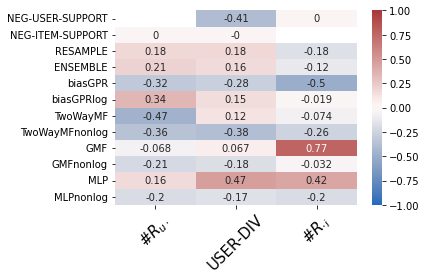

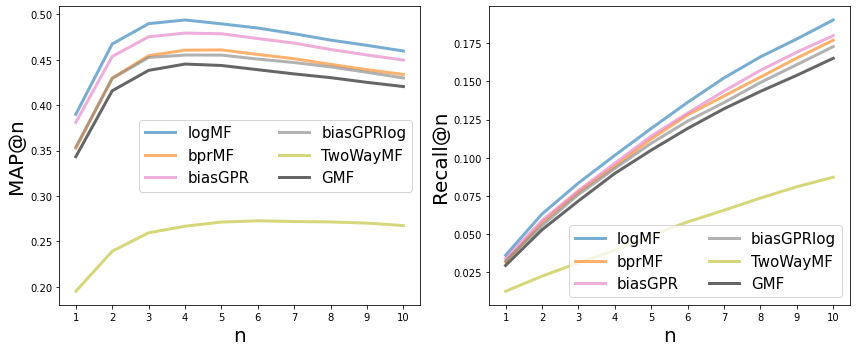

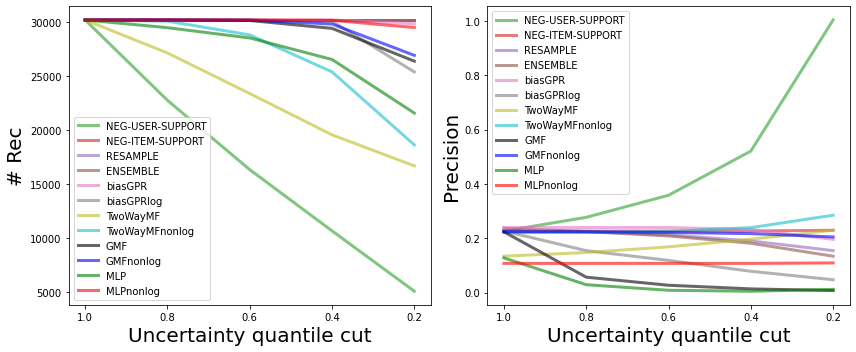

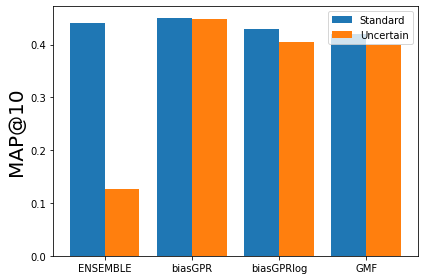

In [20]:
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
order = ['logMF', 'bprMF', 'NEG-USER-SUPPORT', 'NEG-ITEM-SUPPORT', 'RESAMPLE', 'ENSEMBLE', 'biasGPR', 'biasGPRlog', 'TwoWayMF', 'TwoWayMFnonlog', 'GMF', 'GMFnonlog', 'MLP', 'MLPnonlog']
results = dict((key, results[key]) for key in order)
colors = [c for c in list(TABLEAU_COLORS)] + ['k', 'b', 'g', 'r']
colors = {k:c for k, c in zip(results, colors)}

# Rating prediction evaluation
ratings = pd.DataFrame([results[key] for key in results], index=results.keys())[['FCP', 'Concordant uncertainty', 'Discordant uncertainty']]
print(ratings)
# URI and UAC
keys = [key for key in results if key != 'logMF' and key != 'bprMF']
a = pd.DataFrame([results[key]['Rating_rec'] for key in keys], index=keys)[['URI', 'Unc_MAP_corr']]
a['URI'] = [b[-1] for b in a['URI']] 
print(a)

# Correlation plot
corr = np.empty((len(results)-2, 3))
for idx, key in enumerate(keys):
    corr[idx, 0] = results[key]['corr_usup']
    corr[idx, 1] = results[key]['corr_udiv']
    corr[idx, 2] = results[key]['corr_isup']
corr = pd.DataFrame(corr, index=keys, columns=[r'#$R_{u\cdot}$', 'USER-DIV', r'#$R_{\cdot i}$'])
corr.loc['NEG-USER-SUPPORT', r'#$R_{u\cdot}$'] = np.nan
corr.loc['NEG-ITEM-SUPPORT', r'#$R_{\cdot i}$'] = np.nan
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45, fontsize=15)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

# Top-K accuracy metrics
keys = ['logMF', 'bprMF', 'biasGPR', 'biasGPRlog', 'TwoWayMF', 'GMF']
f, ax = plt.subplots(ncols=2, figsize=(12, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['Rating_rec']['MAP'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['Rating_rec']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('n', fontsize=20)
ax[0].set_ylabel('MAP@n', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('n', fontsize=20)
ax[1].set_ylabel('Recall@n', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

# Cuts
keys = [key for key in results if key != 'logMF' and key != 'bprMF']
f, ax = plt.subplots(ncols=2, figsize=(12, 5))
for key in keys:
    ax[0].plot(results[key]['Cuts']['Given'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(results[key]['Cuts']['Hits'] / results[key]['Cuts']['Given'], '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(range(5))
ax[0].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[0].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[0].set_ylabel('# Rec', fontsize=20)
ax[0].legend()
ax[1].set_xticks(range(5))
ax[1].set_xticklabels(np.linspace(1, 0.2, 5).round(2))
ax[1].set_xlabel('Uncertainty quantile cut', fontsize=20)
ax[1].set_ylabel('Precision', fontsize=20)
ax[1].legend()
f.tight_layout()
f.savefig('plots/cuts.pdf')

# Rating prediction evaluation
keys = ['ENSEMBLE', 'biasGPR', 'biasGPRlog', 'GMF']
a = {metric: {key: [results[key]['Rating_rec'][metric][-1]] + [results[key]['Uncertain_rec'][metric][-1]] 
              for key in keys} for metric in ['MAP', 'Recall']}
precision = pd.DataFrame(a['MAP'], index=['Standard', 'Uncertain']).T
f, ax = plt.subplots()
ax.bar(np.arange(len(keys))-0.2, precision['Standard'], 0.4, label='Standard')
ax.bar(np.arange(len(keys))+0.2, precision['Uncertain'], 0.4, label='Uncertain')
ax.set_xticks(np.arange(len(keys)))
ax.set_xticklabels(list(precision.index))
ax.set_ylabel('MAP@10', fontsize=20)
ax.legend()
f.tight_layout()
f.savefig('plots/unc_rank.pdf')

In [25]:
a = np.zeros((10, 5))
for i in a:
    print(i)
a[np.arange(10) // 2 == 0, 1]

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


array([0., 0.])

In [14]:
print('Average item popularity on training: {}'.format(data.item_support[data.train[:, 1]].mean()))
print('Average item popularity on validation: {}'.format(data.item_support[data.val[:, 1]].mean()))
print('Average item popularity on test: {}'.format(data.item_support[data.test[:, 1]].mean()))

Average item popularity on training: 602.0571168183432
Average item popularity on validation: 591.4205711309783
Average item popularity on test: 605.4069095087829


- [X] Check if all models in explicit case are outputting uncertainty properly. 

- [X] BeMF should not borrow the uncertainty metric from the rating case into the recommendation case / BeMF could do simply 1 - P(r > 4) as uncertainty. This would make uncertainty inversely proportional to relevance, but does the absolute values of the numbers still add something?

- [X] Also think about the absolute uncertainty numbers for the other models. Vanilla RRI might be the answer.

- [X] Check giovanni's paper experiment description (especially the early stopping part). There, they use MAP for early stopping as well, which removes the need of negative samples but increase the computational cost. They do validation check every 5 epochs. Their batch size also varies and is sometimes really small, which means that 5 epochs may consist of lots and lots of updates.

## RRI formulation

- Original: $$ \frac{\rho_{ui} - \bar{\rho}}{\sigma_\rho} $$
- Ours: $$ \frac{\rho_{ui} - \bar{\rho_u}}{\sigma_{\rho_u}} $$

We aknowledged that the original form has the problem of penalizing correct recommendations every time that their uncertainty is higher than the average uncertainty. For this reason we changed to the user based form, in which the uncertainties are compared to the user average uncertainty, and therefore a penalty to the RRI value occurs only if the uncertainty of the correct recommendation is higher than the average uncertainty for the user.

Nevertheless, our formulation does not analyze the recommendation in a cross-user aspect. Ideally, if uncertainty is well defined, than we want the recommendation hits to a user to be those with the lowest uncertainty among the recommendations to that user, and also the most precise recommendation sets to be given to the user with the lowest average uncertaity.